### Training Pipeline for FasterRCNN 

- Faster R-CNN gives high accuracy with region-based detection
- ResNet-50 is a balanced backbone for speed vs performance
- Available on PyTorch Hub


In [2]:
import os
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
import torchvision
from torchvision.models.detection import (
    fasterrcnn_resnet50_fpn
)
from torchvision.models.detection.faster_rcnn import (
    FastRCNNPredictor
)
from torch.optim import AdamW
from PIL import Image
import numpy as np
import json
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import Subset
from tqdm import tqdm

Define paths for images and labels

In [19]:
images_root = Path("../data/yolo_data/images")
train_images_dir = images_root / "train"
val_images_dir = images_root / "val"
test_images_dir = images_root / "test"

labels_root = Path("../data/coco_data")
train_labels_path = labels_root / "bdd100k_train_coco.json"
val_labels_path = labels_root / "bdd100k_val_coco.json"


Reference to build custom loader: https://docs.pytorch.org/docs/stable/data.html

In [20]:
class BDDDetectionDataset(Dataset):
    def __init__(self, cocojson_path, image_dir, transform=None):
        self.coco = COCO(cocojson_path)
        self.image_dir = Path(image_dir)
        self.transform = transform

        self.image_ids = [
            img_id for img_id in self.coco.imgs.keys()
            if (self.image_dir / self.coco.imgs[img_id]['file_name']).exists()
            and len(self.coco.getAnnIds(imgIds=img_id)) > 0
        ]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = self.image_dir / image_info['file_name']
        image = Image.open(image_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)

        boxes = []
        labels = []
        areas = []
        iscrowd = []

        for ann in anns:
            x, y, width, height = ann['bbox']
            boxes.append([x, y, x + width, y + height])
            labels.append(ann['category_id'])
            areas.append(ann['area'])
            iscrowd.append(ann['iscrowd'])

        target = {
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64),
            'image_id': torch.tensor([image_id]),
            'area': torch.tensor(areas, dtype=torch.float32),
            'iscrowd': torch.tensor(iscrowd, dtype=torch.int64)
        }

        return image, target

In [21]:
train_dataset = BDDDetectionDataset(
    cocojson_path=train_labels_path,
    image_dir=train_images_dir
)
val_dataset = BDDDetectionDataset(
    cocojson_path=val_labels_path,
    image_dir=val_images_dir
)

loading annotations into memory...
Done (t=3.59s)
creating index...
index created!
loading annotations into memory...
Done (t=0.56s)
creating index...
index created!


Prepprocessing step

In [22]:
preprocess_transform = Compose([   
    ToTensor(),
    Normalize(
        mean=[0.485, 0.456, 0.406],   # ImageNet means to match the model
        std=[0.229, 0.224, 0.225]     # ImageNet stds to match the model
    )
])

train_dataset.transform = preprocess_transform
val_dataset.transform = preprocess_transform

In [23]:
image, target = train_dataset[0]
print(type(image)) 

<class 'torch.Tensor'>


For simplicity, data augmentation is not applied for now... 
But to apply data augmentation, I would choose albumentations and follow the documentation - :
https://albumentations.ai/docs/3-basic-usage/bounding-boxes-augmentations/

In [24]:
def collate_fn(batch):
    return tuple(zip(*batch))

Create dataloaders

In [26]:
train_subset_indices = list(range(16))
train_subset = Subset(train_dataset, train_subset_indices)

val_subset_indices = list(range(8))
val_subset = Subset(val_dataset, val_subset_indices)

train_loader = DataLoader(
    train_subset, 
    batch_size=16,
    shuffle=True,
    num_workers=8,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_subset, 
    batch_size=16,
    shuffle=False,
    num_workers=8,
    collate_fn=collate_fn
)


Visualize sample data

In [32]:
def unnormalize_image(tensor):
    """For visualization, unnormalize a tensor image using ImageNet stats.""" 
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

def plot_image_with_boxes(image, target, category_map=None):
    """
    Plot an image with bounding boxes.

    Args:
        image: PIL.Image or Tensor (C, H, W)
        target: Dict with keys 'boxes', 'labels'
        category_map: dict {id: class_name}
    """
    

    if isinstance(image, torch.Tensor):
        image = unnormalize_image(image).permute(1, 2, 0).clamp(0, 1).numpy()

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    boxes = target['boxes']
    labels = target['labels']

    for i in range(len(boxes)):
        box = boxes[i]
        label = labels[i].item()

        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1

        rect = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)

        if category_map:
            class_name = category_map.get(label, str(label))
            ax.text(
                x1, y1 - 5, class_name,
                color='white', fontsize=10,
                bbox=dict(facecolor='red', edgecolor='none', pad=1)
            )

    ax.axis('off')
    plt.tight_layout()
    plt.show()

In [33]:
print(train_dataset[2])
print(len(train_dataset))
print(len(val_dataset))

(tensor([[[-0.9877, -0.9877, -0.9705,  ..., -0.9705, -0.9705, -0.9705],
         [-1.0219, -1.0219, -1.0048,  ..., -0.9705, -0.9705, -0.9705],
         [-1.0904, -1.0733, -1.0733,  ..., -0.9705, -0.9705, -0.9705],
         ...,
         [-1.8953, -1.8953, -1.8953,  ..., -1.9809, -1.9809, -1.9809],
         [-1.8953, -1.8953, -1.8953,  ..., -1.9638, -1.9638, -1.9638],
         [-1.8953, -1.8953, -1.8953,  ..., -1.9638, -1.9638, -1.9638]],

        [[-1.1253, -1.1253, -1.1078,  ..., -0.6702, -0.6702, -0.6702],
         [-1.1604, -1.1604, -1.1429,  ..., -0.6702, -0.6702, -0.6702],
         [-1.2304, -1.2129, -1.2129,  ..., -0.6702, -0.6702, -0.6702],
         ...,
         [-1.8256, -1.8256, -1.8256,  ..., -1.8957, -1.8957, -1.8957],
         [-1.8256, -1.8256, -1.8256,  ..., -1.8782, -1.8782, -1.8782],
         [-1.8256, -1.8256, -1.8256,  ..., -1.8782, -1.8782, -1.8782]],

        [[-0.9156, -0.9156, -0.8981,  ..., -0.3404, -0.3404, -0.3404],
         [-0.9504, -0.9504, -0.9330,  ..., -

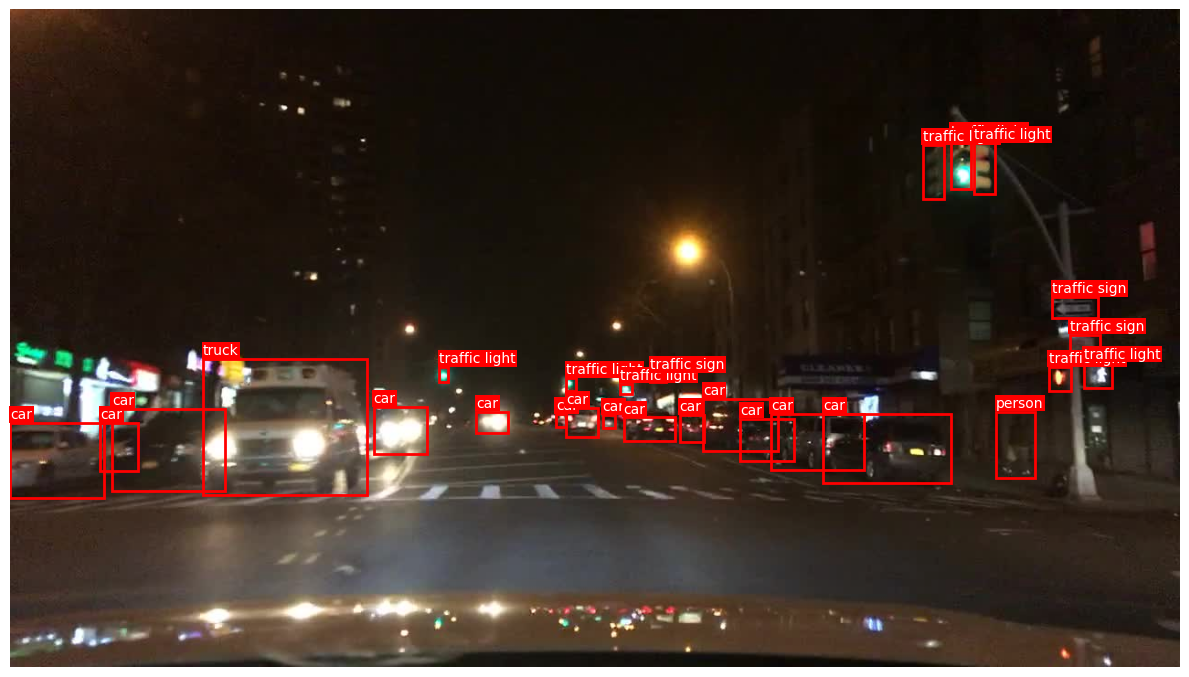

In [34]:
#image, target = train_dataset[0]
#image, target = train_dataset[69862]
image, target = train_dataset[34349]
# image, target = train_dataset[9886]
#image, target = train_dataset[656]
#image, target = train_dataset[10000]

#image, target = val_dataset[0]
#image, target = val_dataset[9999]
#image, target = val_dataset[5675]

category_map = {
    1: 'person',
    2: 'rider',
    3: 'car',
    4: 'bus',
    5: 'truck',
    6: 'bike',
    7: 'motor',
    8: 'traffic light',
    9: 'traffic sign',
    10: 'train'
}

plot_image_with_boxes(image, target, category_map)



Model - FasterRCNN with Resnet50 backbone pretrained on ImageNet

In [35]:
num_classes = 10 + 1  # 10 classes + 1 for background

In [36]:
# Load pre-trained Faster R-CNN
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
print(in_features)

# Replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(
    in_features, num_classes
)

1024


In [23]:
# print(model.backbone)

In [37]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
model.to(device)

cuda


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Set hyperparameters and optimizer













In [40]:
learning_rate = 1e-4
weight_decay = 1e-4
num_epochs = 2

In [41]:
params = [p for p in model.parameters() if p.requires_grad]

optimizer = AdamW(
    params,
    lr=learning_rate,
    weight_decay=weight_decay
)

In [42]:
for epoch in range(num_epochs):
    
    print(f"Epoch [{epoch + 1}/{num_epochs}]")

    model.train()
    loss = 0.0
    batch_count = 0

    for images, targets in tqdm(train_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        total_loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        loss += total_loss.item()
        batch_count += 1


    avg_loss = loss / batch_count
    print(f"Loss: {avg_loss:.4f}")


Epoch [1/2]


100%|██████████| 1/1 [02:15<00:00, 135.85s/it]


Loss: 3.8417
Epoch [2/2]


100%|██████████| 1/1 [02:17<00:00, 137.01s/it]

Loss: 1.8400
